# Numerical validation of controllability of ansatze in Larocca et al., *Quantum* 6 824 (2022)

In [1]:
import os
import logging
import numpy as np
import h5py
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from fastdla.lie_closure import lie_closure
from fastdla.generators.hea import hea_generators
from fastdla.generators.spin_glass import spin_glass_generators
from fastdla.generators.heisenberg_hva import xxz_hva_generators
from fastdla.generators.tfim_hva import tfim_1d_hva_generators
from fastdla.generators.spin_chain import (magnetization_eigenspace, parity_eigenspace,
                                           translation_eigenspace, spin_flip_eigenspace)

logging.basicConfig(level=logging.WARNING)
logging.getLogger('fastdla').setLevel(logging.INFO)
LOG = logging.getLogger('fastdla')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
jax.config.update('jax_enable_x64', True)

In [ ]:
data_file = ''
force_rewrite = False

In [3]:
if data_file and not os.path.exists(data_file):
    with h5py.File(data_file, 'w'):
        pass

### Hardware efficient ansatz

$$
\mathcal{G}_{\mathrm{HEA}} = \left\{ X_n, Y_n \right\}_{n=0}^{N_q-1} \cup
                                     \left\{ \sum_{n=0}^{N_q - 2} Z_n Z_{n+1} \right\}
$$

In [4]:
run_calc = True
if data_file and not force_rewrite:
    with h5py.File(data_file, 'r') as source:
        if 'hea' in source:
            run_calc = False
            group = source['hea']
            nqs = group['num_qubits'][()]
            dla_dims = group['dla_dims'][()]

if run_calc:
    min_nq = 2
    max_nq = 6
    nqs = np.arange(min_nq, max_nq + 1)
    dla_dims = []

    for num_qubits in nqs:
        LOG.info('num_qubits=%d', num_qubits)
        generators = hea_generators(num_qubits=num_qubits).to_matrices()
        dla = lie_closure(generators)
        LOG.info('DLA dimension %d', dla.shape[0])
        dla_dims.append(dla.shape[0])

    if data_file:
        with h5py.File(data_file, 'a') as out:
            if 'hea' in out:
                del out['hea']

            group = out.create_group('hea')
            group.create_dataset('num_qubits', data=nqs)
            group.create_dataset('dla_dims', data=dla_dims)

INFO:fastdla:num_qubits=2
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5
INFO:fastdla._lie_closure_impl.matrix_jax:Found 10 new ops in 0.43s
INFO:fastdla:DLA dimension 15
INFO:fastdla:num_qubits=3
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 7
INFO:fastdla._lie_closure_impl.matrix_jax:Found 56 new ops in 0.43s
INFO:fastdla:DLA dimension 63
INFO:fastdla:num_qubits=4
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 9


Basis size 221; 2000th/24310 commutator [b[62], b[47]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 246 new ops in 1.19s
INFO:fastdla:DLA dimension 255
INFO:fastdla:num_qubits=5


Basis size 249; 4000th/30876 commutator [b[88], b[84]]


INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 11


Basis size 289; 2000th/41616 commutator [b[62], b[47]]
Basis size 474; 4000th/112101 commutator [b[88], b[84]]
Basis size 574; 6000th/164451 commutator [b[109], b[5]]
Basis size 740; 10000th/273430 commutator [b[140], b[130]]
Basis size 802; 12000th/321201 commutator [b[154], b[65]]
Basis size 836; 14000th/349030 commutator [b[166], b[139]]
Basis size 881; 16000th/387640 commutator [b[178], b[69]]
Basis size 908; 18000th/411778 commutator [b[189], b[45]]
Basis size 910; 20000th/413595 commutator [b[199], b[100]]
Basis size 912; 22000th/415416 commutator [b[209], b[55]]
Basis size 914; 24000th/417241 commutator [b[218], b[129]]
Basis size 956; 26000th/456490 commutator [b[227], b[122]]
Basis size 996; 28000th/495510 commutator [b[236], b[34]]
Basis size 1008; 30000th/507528 commutator [b[244], b[110]]
Basis size 1014; 32000th/513591 commutator [b[252], b[122]]
Basis size 1019; 34000th/518671 commutator [b[260], b[70]]
Basis size 1019; 36000th/518671 commutator [b[267], b[222]]
Basis siz

INFO:fastdla._lie_closure_impl.matrix_jax:Found 1012 new ops in 13.26s
INFO:fastdla:DLA dimension 1023
INFO:fastdla:num_qubits=6
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 13


Basis size 261; 2000th/33930 commutator [b[62], b[47]]
Basis size 489; 4000th/119316 commutator [b[88], b[84]]
Basis size 653; 6000th/212878 commutator [b[109], b[5]]
Basis size 874; 10000th/381501 commutator [b[140], b[130]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 1011 new ops in 9.11s
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 1024


Basis size 1028; 12000th/527878 commutator [b[154], b[65]]
Basis size 1176; 14000th/690900 commutator [b[166], b[139]]
Basis size 1238; 16000th/765703 commutator [b[178], b[69]]
Basis size 1302; 18000th/846951 commutator [b[189], b[45]]
Basis size 1411; 20000th/994755 commutator [b[199], b[100]]
Basis size 1476; 22000th/1088550 commutator [b[209], b[55]]
Basis size 1520; 24000th/1154440 commutator [b[218], b[129]]
Basis size 1556; 26000th/1209790 commutator [b[227], b[122]]
Basis size 1580; 28000th/1247410 commutator [b[236], b[34]]
Basis size 1617; 30000th/1306536 commutator [b[244], b[110]]
Basis size 1876; 32000th/1758750 commutator [b[252], b[122]]
Basis size 1995; 34000th/1989015 commutator [b[260], b[70]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 1024 new ops in 31.92s
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2048


Basis size 2089; 36000th/2180916 commutator [b[267], b[222]]
Basis size 2146; 38000th/2301585 commutator [b[275], b[50]]
Basis size 2216; 40000th/2454220 commutator [b[282], b[97]]
Basis size 2238; 42000th/2503203 commutator [b[289], b[95]]
Basis size 2262; 44000th/2557191 commutator [b[296], b[44]]
Basis size 2294; 46000th/2630071 commutator [b[302], b[247]]
Basis size 2424; 48000th/2936676 commutator [b[309], b[105]]
Basis size 2436; 50000th/2965830 commutator [b[315], b[230]]
Basis size 2518; 52000th/3168903 commutator [b[321], b[319]]
Basis size 2518; 54000th/3168903 commutator [b[328], b[44]]
Basis size 2528; 56000th/3194128 commutator [b[334], b[55]]
Basis size 2557; 58000th/3267846 commutator [b[340], b[30]]
Basis size 2563; 60000th/3283203 commutator [b[345], b[315]]
Basis size 2566; 62000th/3290895 commutator [b[351], b[224]]
Basis size 2586; 64000th/3342405 commutator [b[357], b[97]]
Basis size 2602; 66000th/3383901 commutator [b[362], b[297]]
Basis size 2753; 68000th/3788128

INFO:fastdla._lie_closure_impl.matrix_jax:Found 1024 new ops in 84.04s
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 3072


Basis size 3098; 74000th/4797253 commutator [b[384], b[80]]
Basis size 3154; 76000th/4972281 commutator [b[389], b[145]]
Basis size 3215; 78000th/5166505 commutator [b[394], b[185]]
Basis size 3248; 80000th/5273128 commutator [b[399], b[200]]
Basis size 3255; 82000th/5295885 commutator [b[404], b[190]]
Basis size 3258; 84000th/5305653 commutator [b[409], b[155]]
Basis size 3319; 86000th/5506221 commutator [b[414], b[95]]
Basis size 3356; 88000th/5629690 commutator [b[419], b[10]]
Basis size 3459; 90000th/5980611 commutator [b[423], b[324]]
Basis size 3484; 92000th/6067386 commutator [b[428], b[194]]
Basis size 3557; 94000th/6324346 commutator [b[433], b[39]]
Basis size 3563; 96000th/6345703 commutator [b[437], b[297]]
Basis size 3575; 98000th/6388525 commutator [b[442], b[97]]
Basis size 3575; 100000th/6388525 commutator [b[446], b[319]]
Basis size 3591; 102000th/6445845 commutator [b[451], b[74]]
Basis size 3625; 104000th/6568500 commutator [b[455], b[260]]
Basis size 3657; 106000th/6

INFO:fastdla._lie_closure_impl.matrix_jax:Found 1023 new ops in 649.26s
INFO:fastdla:DLA dimension 4095


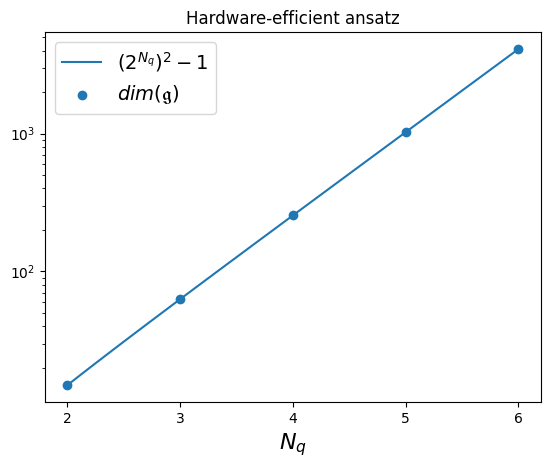

In [5]:
x = np.linspace(nqs[0], nqs[-1], 100)
plt.plot(x, (2 ** x) ** 2 - 1, label='$(2^{N_q})^2-1$')
plt.scatter(nqs, dla_dims, label=r'$dim(\mathfrak{g})$')
plt.yscale('log')
plt.title('Hardware-efficient ansatz')
plt.xlabel('$N_q$', fontsize=16)
plt.xticks(nqs, labels=[f'{i}' for i in nqs])
plt.legend(fontsize=14);

### Spin glass



In [6]:
run_calc = True
if data_file and not force_rewrite:
    with h5py.File(data_file, 'r') as source:
        if 'spin_glass' in source:
            run_calc = False
            group = source['spin_glass']
            nqs = group['num_qubits'][()]
            dla_dims = group['dla_dims'][()]

# if run_calc:
if True:
    min_nq = 3
    max_nq = 5
    nqs = np.arange(min_nq, max_nq + 1)
    dla_dims = []

    for num_qubits in nqs:
        LOG.info('num_qubits=%d', num_qubits)
        generators = spin_glass_generators(num_qubits=num_qubits).to_matrices()
        dla = lie_closure(generators)
        LOG.info('DLA dimension %d', dla.shape[0])
        dla_dims.append(dla.shape[0])

    if data_file:
        with h5py.File(data_file, 'a') as out:
            if 'spin_glass' in out:
                del out['spin_glass']

            group = out.create_group('spin_glass')
            group.create_dataset('num_qubits', data=nqs)
            group.create_dataset('dla_dims', data=dla_dims)

INFO:fastdla:num_qubits=3
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 61 new ops in 0.36s
INFO:fastdla:DLA dimension 63
INFO:fastdla:num_qubits=4
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 253 new ops in 0.45s
INFO:fastdla:DLA dimension 255
INFO:fastdla:num_qubits=5
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 1021 new ops in 1.04s
INFO:fastdla:DLA dimension 1023


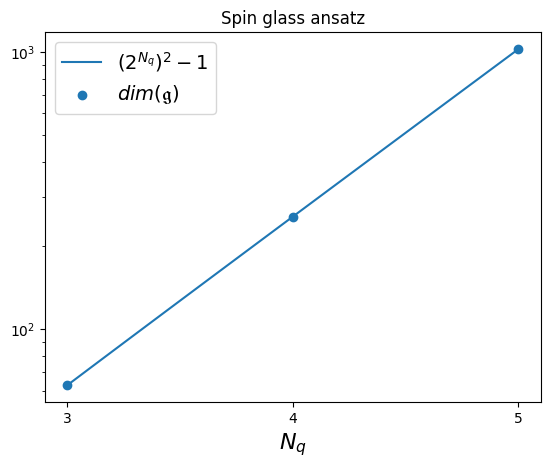

In [7]:
x = np.linspace(nqs[0], nqs[-1], 100)
plt.plot(x, (2 ** x) ** 2 - 1, label='$(2^{N_q})^2-1$')
plt.scatter(nqs, dla_dims, label=r'$dim(\mathfrak{g})$')
plt.yscale('log')
plt.title('Spin glass ansatz')
plt.xlabel('$N_q$', fontsize=16)
plt.xticks(nqs, labels=[f'{i}' for i in nqs])
plt.legend(fontsize=14);

### $XXZ$ model (subspace controllable)

In [8]:
run_calc = True
if data_file and not force_rewrite:
    with h5py.File(data_file, 'r') as source:
        if 'xxz' in source:
            run_calc = False
            group = source['xxz']
            nspins = group['num_spins'][()]
            subspace_dims = group['subspace_dims'][()]
            dla_dims = group['dla_dims'][()]

if run_calc:
    min_nspin = 4
    max_nspin = 8
    nspins = np.arange(min_nspin, max_nspin + 1, 2)
    parity = 1
    subspace_dims = np.zeros((nspins.shape[0], max_nspin // 2 + 1), dtype=int)
    dla_dims = np.zeros((nspins.shape[0], max_nspin // 2 + 1), dtype=int)

    for ispin, num_qubits in enumerate(nspins):
        LOG.info('num_spins=%d', num_qubits)
        generators = xxz_hva_generators(num_qubits).to_matrices()
        parity_subspace = parity_eigenspace(parity, num_spins=num_qubits, npmod=jnp)
        for imag, magnetization in enumerate(range(0, num_qubits + 1, 2)):
            LOG.info('magnetization=%d', magnetization)
            subspace = magnetization_eigenspace(magnetization, basis=parity_subspace, npmod=jnp)
            LOG.info('Subspace dimension %d', subspace.shape[1])
            generators_reduced = jnp.einsum('ij,gik,kl->gjl', subspace.conjugate(), generators,
                                            subspace)
            dla = lie_closure(generators_reduced)
            LOG.info('DLA dimension %d', dla.shape[0])
            subspace_dims[ispin, imag] = subspace.shape[1]
            dla_dims[ispin, imag] = dla.shape[0]

    if data_file:
        with h5py.File(data_file, 'a') as out:
            if 'xxz' in out:
                del out['xxz']

            group = out.create_group('xxz')
            group.create_dataset('num_spins', data=nspins)
            group.create_dataset('subspace_dims', data=subspace_dims)
            group.create_dataset('dla_dims', data=dla_dims)

INFO:fastdla:num_spins=4
INFO:fastdla:magnetization=0
INFO:fastdla:Subspace dimension 4
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5
INFO:fastdla._lie_closure_impl.matrix_jax:Found 10 new ops in 0.35s
INFO:fastdla:DLA dimension 15
INFO:fastdla:magnetization=2
INFO:fastdla:Subspace dimension 2
INFO:fastdla:DLA dimension 3
INFO:fastdla:magnetization=4
INFO:fastdla:Subspace dimension 1
INFO:fastdla:DLA dimension 0
INFO:fastdla:num_spins=6
INFO:fastdla:magnetization=0
INFO:fastdla:Subspace dimension 10
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5
INFO:fastdla._lie_closure_impl.matrix_jax:Found 94 new ops in 0.46s
INFO:fastdla:DLA dimension 99
INFO:fastdla:magnetization=2
INFO:fastdla:Subspace dimension 9
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5
INFO:fastdla._lie_closure_impl.matrix_jax:Found 75 new ops in 0.42s
INFO:fastdla:DLA dimension 80
INFO:fastdla:magnetization=4
INFO:fastdla:Subspace dimens

Basis size 1195; 2000th/713415 commutator [b[62], b[47]]
Basis size 1438; 4000th/1033203 commutator [b[88], b[84]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 419 new ops in 3.05s
INFO:fastdla:DLA dimension 1443
INFO:fastdla:magnetization=2
INFO:fastdla:Subspace dimension 28
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5
INFO:fastdla._lie_closure_impl.matrix_jax:Found 778 new ops in 1.43s
INFO:fastdla:DLA dimension 783
INFO:fastdla:magnetization=4


Basis size 782; 2000th/305371 commutator [b[62], b[47]]


INFO:fastdla:Subspace dimension 16
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 5


Basis size 254; 2000th/32131 commutator [b[62], b[47]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 250 new ops in 1.24s
INFO:fastdla:DLA dimension 255
INFO:fastdla:magnetization=6
INFO:fastdla:Subspace dimension 4
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 4
INFO:fastdla._lie_closure_impl.matrix_jax:Found 11 new ops in 0.35s
INFO:fastdla:DLA dimension 15
INFO:fastdla:magnetization=8
INFO:fastdla:Subspace dimension 1
INFO:fastdla:DLA dimension 0


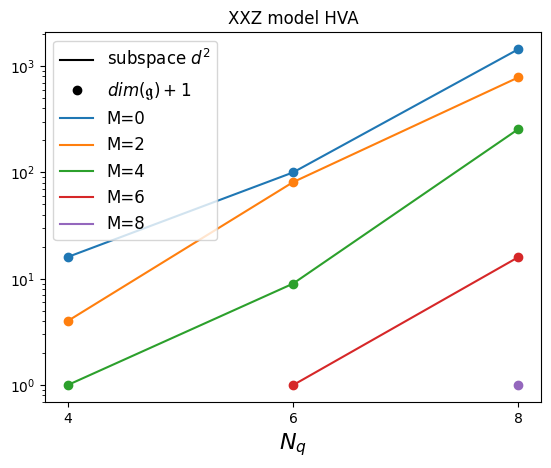

In [9]:
from matplotlib.lines import Line2D

handles = [Line2D([0, 1], [0, 1], color='k'), Line2D([], [], color='k', linestyle='none', marker='o')]
labels = ['subspace $d^2$', r'$dim(\mathfrak{g})+1$']
for imag in range(nspins[-1] // 2 + 1):
    magnetization = imag * 2
    mask = nspins >= magnetization
    line, = plt.plot(nspins[mask], np.square(subspace_dims[mask][:, imag]))
    plt.scatter(nspins[mask], dla_dims[mask][:, imag] + 1)
    handles.append(line)
    labels.append(f'M={magnetization}')
plt.yscale('log')
plt.title('XXZ model HVA')
plt.xlabel('$N_q$', fontsize=16)
plt.xticks(nspins, labels=[f'{i}' for i in nspins])
plt.legend(handles, labels, fontsize=12);

### TFIM HVA

In [10]:
run_calc = True
if data_file and not force_rewrite:
    with h5py.File(data_file, 'r') as source:
        if 'tfim' in source:
            run_calc = False
            group = source['tfim']
            nspins = group['num_spins'][()]
            dla_dims = group['dla_dims'][()]

if run_calc:
    min_nspin = 4
    max_nspin = 10
    nspins = np.arange(min_nspin, max_nspin + 1, 2)
    parity = 1
    z2_eigval = 1
    jphase = 0
    subspace_dims = np.zeros((nspins.shape[0], 2), dtype=int)
    dla_dims = np.zeros((nspins.shape[0], 2), dtype=int)

    for ispin, num_qubits in enumerate(nspins):
        LOG.info('num_spins=%d', num_qubits)
        z2_subspace = spin_flip_eigenspace(z2_eigval, num_spins=num_qubits, npmod=jnp)
        for ibc, bc in enumerate(['open', 'periodic']):
            LOG.info('boundary condition: %s', bc)
            generators = tfim_1d_hva_generators(num_qubits, boundary_condition=bc).to_matrices()
            if bc == 'open':
                subspace = parity_eigenspace(parity, basis=z2_subspace, npmod=jnp)
            else:
                subspace = translation_eigenspace(jphase, basis=z2_subspace, npmod=jnp)
            LOG.info('Subspace dimension %d', subspace.shape[1])
            generators_reduced = jnp.einsum('ij,gik,kl->gjl', subspace.conjugate(), generators,
                                            subspace)
            dla = lie_closure(generators_reduced)
            LOG.info('DLA dimension %d', dla.shape[0])
            subspace_dims[ispin, ibc] = subspace.shape[1]
            dla_dims[ispin, ibc] = dla.shape[0]

    if data_file:
        with h5py.File(data_file, 'a') as out:
            if 'tfim' in out:
                del out['tfim']

            group = out.create_group('tfim')
            group.create_dataset('num_spins', data=nspins)
            group.create_dataset('dla_dims', data=dla_dims)

INFO:fastdla:num_spins=4
INFO:fastdla:boundary condition: open
INFO:fastdla:Subspace dimension 6
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 13 new ops in 0.40s
INFO:fastdla:DLA dimension 15
INFO:fastdla:boundary condition: periodic
INFO:fastdla:Subspace dimension 4
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 4 new ops in 0.34s
INFO:fastdla:DLA dimension 6
INFO:fastdla:num_spins=6
INFO:fastdla:boundary condition: open
INFO:fastdla:Subspace dimension 20
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 33 new ops in 0.64s
INFO:fastdla:DLA dimension 35
INFO:fastdla:boundary condition: periodic
INFO:fastdla:Subspace dimension 8
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 7 new ops in 

Basis size 64; 2000th/2016 commutator [b[62], b[47]]


INFO:fastdla:Subspace dimension 20
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 10 new ops in 0.47s
INFO:fastdla:DLA dimension 12
INFO:fastdla:num_spins=10
INFO:fastdla:boundary condition: open
INFO:fastdla:Subspace dimension 272
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2


Basis size 100; 2000th/4950 commutator [b[62], b[47]]
Basis size 100; 4000th/4950 commutator [b[88], b[84]]


INFO:fastdla._lie_closure_impl.matrix_jax:Found 98 new ops in 92.57s
INFO:fastdla:DLA dimension 100
INFO:fastdla:boundary condition: periodic
INFO:fastdla:Subspace dimension 56
INFO:fastdla._lie_closure_impl.matrix_jax:Current Lie algebra dimension: 2
INFO:fastdla._lie_closure_impl.matrix_jax:Found 13 new ops in 0.56s
INFO:fastdla:DLA dimension 15


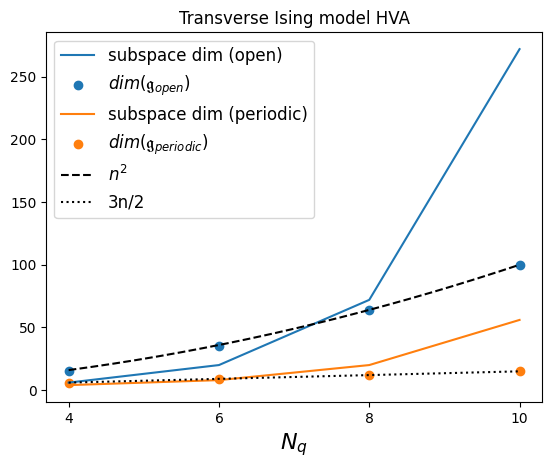

In [11]:
for ibc, bc in enumerate(['open', 'periodic']):
    plt.plot(nspins, subspace_dims[:, ibc], label=f'subspace dim ({bc})')
    plt.scatter(nspins, dla_dims[:, ibc], label=fr'$dim(\mathfrak{{g}}_{{{bc}}})$')

x = np.linspace(nspins[0], nspins[-1], 200)
plt.plot(x, np.square(x), color='k', linestyle='--', label='$n^2$')
plt.plot(x, 1.5 * x, color='k', linestyle=':', label='3n/2')
plt.title('Transverse Ising model HVA')
plt.xlabel('$N_q$', fontsize=16)
plt.xticks(nspins, labels=[f'{i}' for i in nspins])
plt.legend(fontsize=12);